In [1]:
import tensorflow as tf
from tensorflow import keras
from functools import partial
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import wandb
from wandb.keras import WandbCallback

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [71]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


In [82]:
model = keras.models.Sequential()
model.add(DefaultConv2D(32, kernel_size=7, strides=2,
                        input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 32
for filters in [32] * 3 + [64] * 4 + [128] * 6 + [256] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [83]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

metric = "val_accuracy"

# checkpoint = ModelCheckpoint("resnet_1.h5", monitor= metric, verbose=1, save_best_only=True,
#                              save_weights_only=False, mode='auto')

In [84]:
from tensorflow.keras.optimizers import Adam
s = 20 * len(train_images) // 2048
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.001, s, 0.9)
n_epochs = 300
batch = 2048
opt = Adam(learning_rate, amsgrad=True)

In [85]:
print(s)

488


In [86]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=n_epochs, 
                     validation_data=(test_images, test_labels), use_multiprocessing=True,
                   callbacks=[es], batch_size=batch)


Epoch 1/300
25/25 [==============================] - 5s 200ms/step - loss: 2.1371 - accuracy: 0.3125 - val_loss: 2.2978 - val_accuracy: 0.1223
Epoch 2/300
25/25 [==============================] - 4s 147ms/step - loss: 2.0221 - accuracy: 0.4341 - val_loss: 2.2768 - val_accuracy: 0.1789
Epoch 3/300
25/25 [==============================] - 4s 148ms/step - loss: 1.9735 - accuracy: 0.4837 - val_loss: 2.2715 - val_accuracy: 0.1475
Epoch 4/300
25/25 [==============================] - 4s 149ms/step - loss: 1.9408 - accuracy: 0.5160 - val_loss: 2.3279 - val_accuracy: 0.1116
Epoch 5/300
25/25 [==============================] - 4s 148ms/step - loss: 1.9142 - accuracy: 0.5438 - val_loss: 2.3422 - val_accuracy: 0.1100
Epoch 6/300
25/25 [==============================] - 4s 147ms/step - loss: 1.8983 - accuracy: 0.5596 - val_loss: 2.2840 - val_accuracy: 0.1671
Epoch 7/300
25/25 [==============================] - 4s 148ms/step - loss: 1.8797 - accuracy: 0.5787 - val_loss: 2.2922 - val_accuracy: 0.1648

Epoch 58/300
25/25 [==============================] - 4s 145ms/step - loss: 1.5987 - accuracy: 0.8622 - val_loss: 1.8318 - val_accuracy: 0.6268
Epoch 59/300
25/25 [==============================] - 4s 144ms/step - loss: 1.5965 - accuracy: 0.8643 - val_loss: 1.8097 - val_accuracy: 0.6490
Epoch 60/300
25/25 [==============================] - 4s 148ms/step - loss: 1.5962 - accuracy: 0.8647 - val_loss: 1.8023 - val_accuracy: 0.6572
Epoch 61/300
25/25 [==============================] - 4s 146ms/step - loss: 1.5916 - accuracy: 0.8693 - val_loss: 1.7799 - val_accuracy: 0.6790
Epoch 62/300
25/25 [==============================] - 4s 146ms/step - loss: 1.5914 - accuracy: 0.8700 - val_loss: 1.8104 - val_accuracy: 0.6493
Epoch 63/300
25/25 [==============================] - 4s 145ms/step - loss: 1.5861 - accuracy: 0.8747 - val_loss: 1.8000 - val_accuracy: 0.6594
Epoch 64/300
25/25 [==============================] - 4s 146ms/step - loss: 1.5847 - accuracy: 0.8763 - val_loss: 1.8319 - val_accuracy:

Epoch 115/300
25/25 [==============================] - 4s 146ms/step - loss: 1.5357 - accuracy: 0.9254 - val_loss: 1.7700 - val_accuracy: 0.6896
Epoch 116/300
25/25 [==============================] - 4s 147ms/step - loss: 1.5358 - accuracy: 0.9255 - val_loss: 1.7694 - val_accuracy: 0.6897
Epoch 117/300
25/25 [==============================] - 4s 147ms/step - loss: 1.5356 - accuracy: 0.9255 - val_loss: 1.7815 - val_accuracy: 0.6776
Epoch 118/300
25/25 [==============================] - 4s 147ms/step - loss: 1.5349 - accuracy: 0.9262 - val_loss: 1.7751 - val_accuracy: 0.6848
Epoch 119/300
25/25 [==============================] - 4s 147ms/step - loss: 1.5346 - accuracy: 0.9264 - val_loss: 1.7690 - val_accuracy: 0.6915
Epoch 120/300
25/25 [==============================] - 4s 147ms/step - loss: 1.5349 - accuracy: 0.9262 - val_loss: 1.7690 - val_accuracy: 0.6902
Epoch 121/300
25/25 [==============================] - 4s 151ms/step - loss: 1.5344 - accuracy: 0.9268 - val_loss: 1.7687 - val_ac

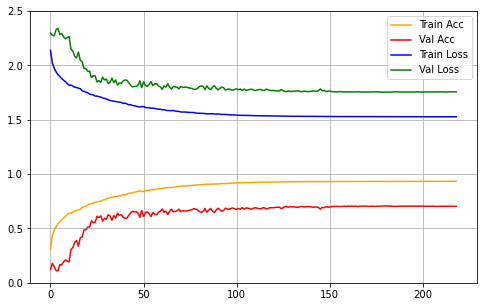

In [87]:
plt.figure(figsize=(8,5))
# plt.plot(np.arange(0,31),history.history['accuracy'], color='orange')
# plt.plot(np.arange(0,31),history.history['loss'],'b')
# plt.plot(np.arange(0,31)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
# plt.plot(np.arange(0,31)+0.5,history.history['val_loss'],'g')
plt.plot(history.history['accuracy'],color='orange')
plt.plot(history.history['val_accuracy'],'r')
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'g')
plt.legend(['Train Acc','Val Acc','Train Loss','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 2.5) # set the vertical range to [0-1] 
plt.show()

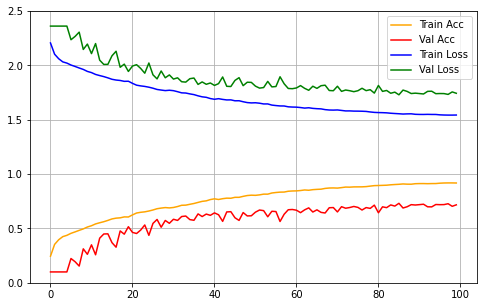

In [70]:
plt.figure(figsize=(8,5))
# plt.plot(np.arange(0,31),history.history['accuracy'], color='orange')
# plt.plot(np.arange(0,31),history.history['loss'],'b')
# plt.plot(np.arange(0,31)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
# plt.plot(np.arange(0,31)+0.5,history.history['val_loss'],'g')
plt.plot(history.history['accuracy'],color='orange')
plt.plot(history.history['val_accuracy'],'r')
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'g')
plt.legend(['Train Acc','Val Acc','Train Loss','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 2.5) # set the vertical range to [0-1] 
plt.show()